# Trabalho Unidade 03 - Análise de hashtags relacionadas a criptomoedas no Twitter

Autores:

* Darlan de Castro Silva Filho - 20200000607;
* Marcos Henrique Fernandes Marcone - 20200000760;

Disciplina: IMD1155 - ANÁLISE DE REDES - T01 (2021.2)

Professor: Ivanovitch Medeiros Dantas da Silva

## Análise de hashtags relacionadas a criptomoedas no Twitter


O trabalho tem como objetivo a análise das hashtags mais comumente encontradas no Twitter relacionadas ao mundo das criptomoedas.

Para isso ser feito foram escolhidas as 10 criptomoedas com o maior valor de mercado no dia 09 de Fevereiro de 2022. Para isso foi utilizado o site [Coin Market Cap](https://coinmarketcap.com/).

Para isso ser feito foram escolhidas as 10 criptomoedas com o maior valor de mercado no dia **09 de Fevereiro de 2022**. Assim as 180 requisições que são disponibilizadas pela API do Twitter, no intervalo de 15 minutos, foram divididas na busca de 10 *hashtags*. Cada criptomoeda foi representada com a sigla como chave de pesquisa. 

Ao todo, ao longo de mais de uma semana foram obtidos mais de 127000 tweets formando uma base dados bem sólida. Dessa forma, foi possível analisar quais são os tópicos que mais estão ligados quando o assunto é criptomoedas no Twitter.

Para acessar a segunda parte deste trabalho, que é o grafo obtido através dos dados deste notebook, basta clicar no seguinte link: [link](https://drive.google.com/file/d/1xTMFlQgPWho3B9NzvDndZJ4jmmYRpUXV/view?usp=sharing).


In [ ]:
# Instalando o nxviz e o networkx
!pip install nxviz==0.6.3 networkx

In [ ]:
# Montando o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importação das bibliotecas que serão utilizadas durante a análise
import json
import pandas as pd
from tqdm import tqdm 
import networkx as nx
import nxviz
from nxviz.plots import CircosPlot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import os, random

In [ ]:
# Download do dataset e do graphml
!gdown https://drive.google.com/uc?id=1-4BIILGxf68lSC-yQ-Eel_LjEB3DnlzT
!gdown https://drive.google.com/uc?id=1IfUBh4rQVmq2gJJuQUbbTstLiXbKo1W1
PATH_DATAFRAME = '/dataframeTemporario.csv'
PATH_GRAPH = '/hashtags_crypto.graphml'

### Organização do dataset

O dataset é organizado com os seguintes campos:

* **user_screen_name**: Identificador textual único do usuário ("@");
* **user_location**: Localização do usuário;
* **user_name**: Nome do usuário;
* **favorite_count**: Quantidade de favoritos do tweet;
* **created_at**: Quando o tweet foi criado;
* **retweet_count**: Quantidade de retweets do tweet;
* **id**: Identificador numérico único do tweet;
* **hashtags**: Lista com as hashtags mencionadas no tweet.

In [ ]:
# Carregamento do dataset e leitura das suas dimensões
df = pd.read_csv(PATH_DATAFRAME)
df.shape

(127058, 8)

## Grafo

O grafo a ser gerado é **não-direcionado** e **ponderado**. Em que os nós são as **hashtags**, e elas são ligados através de uma aresta se aparecem em um mesmo tweet. Já o peso das arestas representa a quantidade de vezes em que as hashtags apareceram juntas contando todos os tweets. Assim as arestas podem ser entendidas como a frequência em que duas hashtags distintas aparecem em um tweet. 

A fim de simplificar o grafo gerado através dos tweets são feitos alguns filtros. Primeiramente, antes da inserção do grafo são descartados tweets que não contenham nenhuma hashtags no seu texto, após a inserção no dataset são removidos os tweets com ids iguais (tweets duplicados) e por fim removem-se os self-loops, que são arestas que saem e incidem sobre um mesmo nó.

In [ ]:
# Criação e povoamento do grafo com os dados dos tweets previamente selecionados
G = nx.Graph()
for hashtagsStr in df['hashtags']:
  hashtags = hashtagsStr.lower().strip("']['").split("', '")
  for (index, baseHashtag) in enumerate(hashtags):
    for indexActualHashtag in range(index, len(hashtags)):
      actualHashtag = hashtags[indexActualHashtag]
      if G.has_edge(baseHashtag, actualHashtag):
          G.edges[baseHashtag, actualHashtag]['weight'] += 1
      else:
          G.add_edge(baseHashtag, actualHashtag, weight=1)

In [ ]:
# Remove todas as arestas que estão em loop consigo mesma
G.remove_edges_from(nx.selfloop_edges(G))

In [ ]:
# Informações da rede
numeroDeNos = G.number_of_nodes()
numeroDeArestas = G.number_of_edges()
print('Número de nós:', numeroDeNos)
print('Número de arestas:', numeroDeArestas)

Número de nós: 10581
Número de arestas: 73349


In [ ]:
# Verificando se o grafo é conectado
print("Grafo eh conectado?", nx.is_connected(G))
print("Número de componentes conectadas", nx.number_connected_components(G))

Grafo eh conectado? False
Número de componentes conectadas 490


In [ ]:
# Se o grafo g não for conectado pode-se atualizar o g com a maior componente conectada do grafo original
gcc = sorted(nx.connected_components(G), key=len, reverse=True)
novoG = G.subgraph(gcc[0])
G = novoG

In [ ]:
# Informações do GCC
numeroDeNos = G.number_of_nodes()
numeroDeArestas = G.number_of_edges()
print('Número de nós:', numeroDeNos)
print('Número de arestas:', numeroDeArestas)

Número de nós: 9907
Número de arestas: 72984


In [ ]:
# Exporta a rede no formato .graphml
nx.write_graphml(G, PATH_GRAPH)

Ao final, com a amostra selecionada a rede ficou com:

* 9907 nós;
* 72984 arestas.

## Análise de dados

Esta seção apresenta as seguintes análises em relação à rede:

 * Excentricidade, diâmetro, periferia, raio e centro;
 * Degree, Closeness, Betweenness and Eigenvector Centrality;

Para cada métrica são apresentadas imagens da rede, assim como são listados os **Top 10** vértices.

Além disso, são apresentadas análides bivariadas e multivariadas para todos os tipos de centralidade.

Por fim é realizada a decomposição da rede em que se obtém os 2 k-cores mais profundos.

**OBS:** **é preciso destacar que apesar de ser um grafo ponderado, para o cálculo de todas as métricas não foram considerados os pesos das arestas. Isso foi feito para tornar os cálculos e as interpretações mais simples.**

In [ ]:
# Spring Layout
pos = nx.spring_layout(G, seed=123456, k=0.5)

### Excentricidade 

In [ ]:
# Excentricidade Normalizada da Rede
eccentricity = nx.eccentricity(G)

#### Gráfico

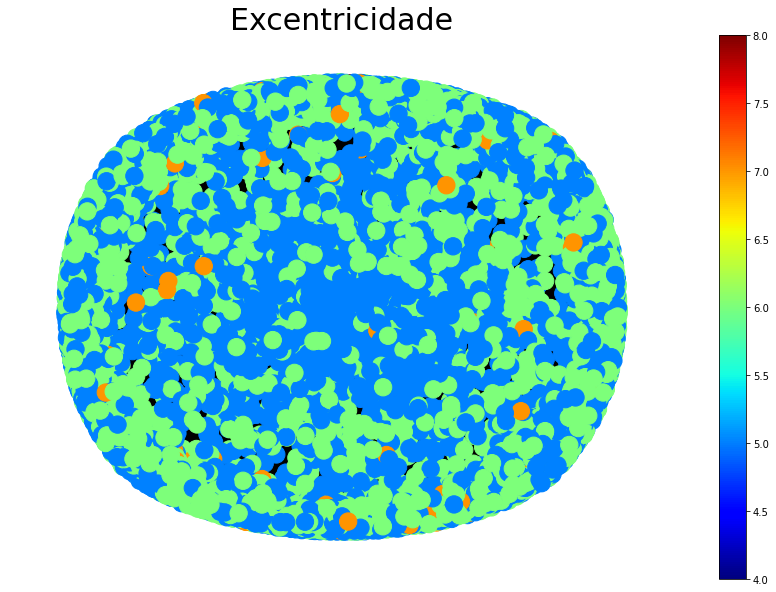

In [ ]:
# Excentricidade
fig, ax = plt.subplots(1,1,figsize=(15,10))
color = list(dict(eccentricity).values())
nx.draw_networkx_edges(G,
                       pos=pos,
                       alpha=0.4, ax=ax)
nodes = nx.draw_networkx_nodes(G,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax)
plt.title("Excentricidade", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)
plt.show()

Analisando o gráfico de excentricidade da rede nota-se que existe uma grande quantidade de nós com a tonalidade azul clara, indicando que o seu maior menor caminho em relação aos outros nós está em torno de cinco arestas. Mas além disso há uma quantidade considerável de nós com uma cor esverdeada representando uma excentricidade em torno de seis de arestas. Também nota-se que há nós, em menor quantidade, com um tom alaranjado simbolizando os nós com excentricidade igual a sete.

#### Diâmetro

In [ ]:
# Diâmetro da Rede
diametro = nx.diameter(G)
print("Diâmetro da rede: {}".format(diametro))

Diâmetro da rede: 8


O diâmetro da rede é 8, representado que a maior excentricidade entre dois nós dessa rede possui 8 arestas.

#### Periferia

In [ ]:
periferia = nx.periphery(G)
print("Comprimento da periferia: {}".format(len(periferia)))
print("Periferia da rede: {}".format(periferia))

Comprimento da periferia: 12
Periferia da rede: ['vecarbon', 'longomontanus', 'passiv', 'verdienen', 'internet', 'email', 'recovery', 'snapchatdown', 'instagramdown', 'accounts', 'bullialdus', 'plato']


A periferia da rede é formada por **12** nós, indicando que esses nós possuem excentricidade igual a 8.


#### Raio

In [ ]:
raio = nx.radius(G)
print("Raio da rede: {}".format(raio))

Raio da rede: 4


O raio da rede é 4, representado que a menor excentricidade entre dois nós dessa rede possui 4 arestas.

Por fim, é importante notar que apesar de ser uma rede com mais de 9000 nós e 70000 arestas, o raio e o diâmetro da rede são extremamente pequenos, representado que os nós estão bem próximos uns com os outros.

#### Centro

In [ ]:
centro = nx.center(G)
print("Comprimento do centro: {}".format(len(centro)))
print("Centro da rede: {}".format(centro))

Comprimento do centro: 10
Centro da rede: ['btc', 'bitcoin', 'cryptocurrency', 'crypto', 'blockchain', 'metaverse', 'bnb', 'news', 'staking', 'wagmi']


O centro da rede é formada por **10** nós, indicando que esses nós possuem excentricidade igual a 4.


### Degree Centrality

In [ ]:
# Degree Centrality
degree = nx.degree_centrality(G)

In [ ]:
# Gera uma sequência decrescente dos graus dos nós
degreeOrdenados = sorted(degree, key=degree.get, reverse=True)

In [ ]:
# Gera uma sequência decrescente dos graus dos nós
grausNos = [G.degree(hashtag) for hashtag in degreeOrdenados]

#### Gráfico

Calculating
Ploting...


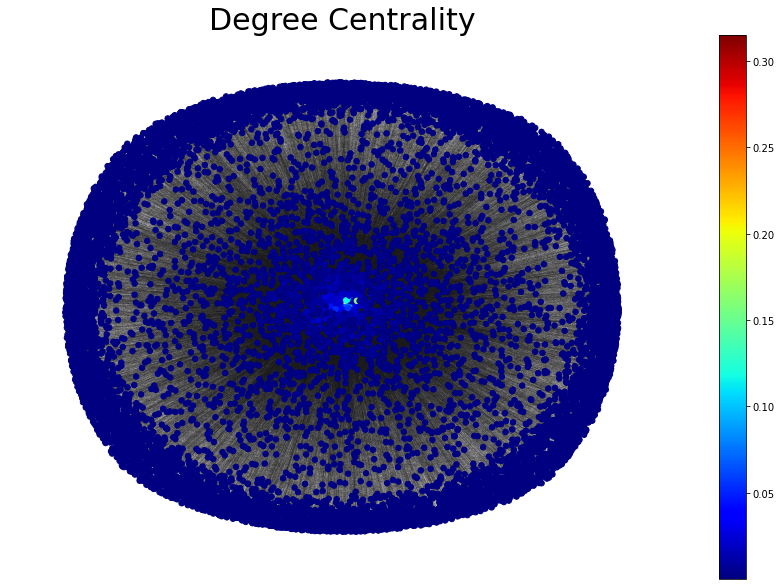

In [ ]:
# Degree centrality
fig, ax = plt.subplots(1,1,figsize=(15,10))
print("Calculating")
color = list(dict(degree).values())
print("Ploting...")
nx.draw_networkx_edges(G,
                       pos=pos, width=0.05,
                       alpha=0.6, ax=ax)
nodes = nx.draw_networkx_nodes(G,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size=30)
plt.title("Degree Centrality", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)

Analisando o gráfico para o Degree Centrality nota-se que a grande maioria dos nós está conectada a outros pouquíssimos nós ao se comparar com a quantidade de vértices presentes na rede. Por isso o Degree Centrality concentra-se num valor em torno de 0.05. Ainda assim, há uma pequena quantidade de nós que se mostram com um grau levemente maior que a média dos outros.

#### Top 10 vértices

In [ ]:
print('Top 10 vértices:')
i = 0
for hashtag in degreeOrdenados:
  if i == 10:
    break
  print("{:^20} {:5.4f} {:5}".format(hashtag, degree[hashtag], G.degree(hashtag)))
  i += 1

Top 10 vértices:
        btc          0.3149  3119
        eth          0.2489  2466
       crypto        0.2041  2022
        nft          0.1868  1850
        bnb          0.1722  1706
        luna         0.1660  1644
      bitcoin        0.1659  1643
        xrp          0.1405  1392
        ada          0.1369  1356
        usdt         0.1170  1159


Analisando os Top 10 vértices observa-que o nó que possui o maior grau, que é de 3119, ainda está muito distante da quantidade de nós da rede que é em torno de 9900. Dessa forma, percebe-se que há uma grande variedade de hashtags nos tweets e que eles não se repetem num grau tão grande.

#### Análise Bivariada

##### PDF (Probability Density Function)

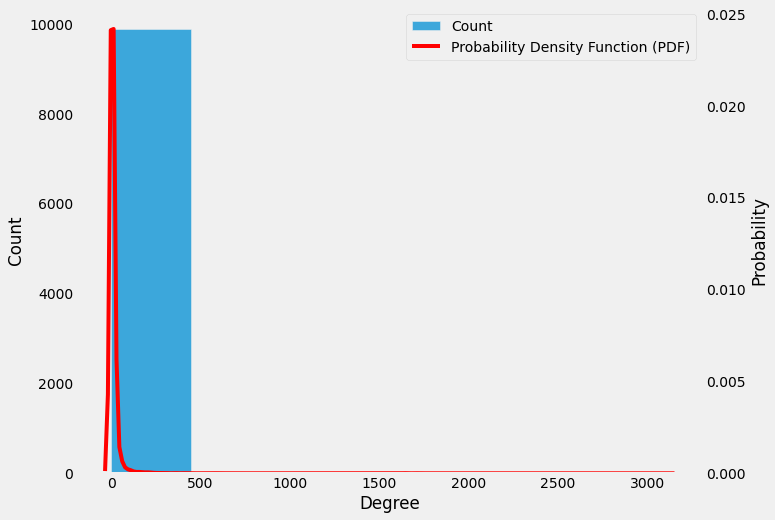

In [ ]:
# Análise bivariada degree centrality
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1,1,figsize=(10,8))
sns.histplot(grausNos, bins=7, label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(grausNos, color='r',label="Probability Density Function (PDF)",ax=ax2)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")
plt.show()

A Função de Densidade de Probabilidade confirma o que foi apresentado anteriormente com uma esmagadora maioria dos nós com o grau baixo (em torno de 0 a 250). Pouquíssimos são os nós que possuem um grau superior a 500.




### Closeness Centrality

In [ ]:
closeness = nx.closeness_centrality(G)

In [ ]:
# Gera uma sequência decrescente da closeness centrality dos nós
closenessOrdenados = sorted(closeness, key=closeness.get, reverse=True)

In [ ]:
closenessNos = [closeness[hashtag] for hashtag in closenessOrdenados]

#### Gráfico

Calculating
Ploting...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


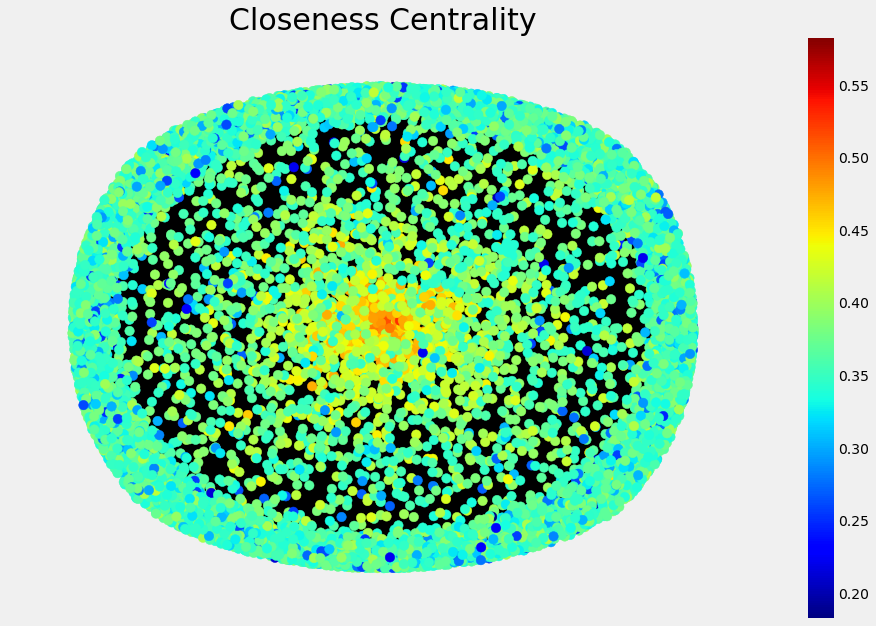

In [ ]:
# Closeness centrality
fig, ax = plt.subplots(1,1,figsize=(15,10))
print("Calculating")
color = list(dict(closeness).values())
print("Ploting...")
nx.draw_networkx_edges(G,
                       pos=pos,
                       alpha=0.4, ax=ax)
nodes = nx.draw_networkx_nodes(G,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size=90)

plt.title("Closeness Centrality", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)

Analisando o gráfico para o Closeness Centrality nota-se que há uma diversidade nos valores. Percebe-se que a grande maioria dos nós possui um Closeness Centrality em torno de 0.35 a 0.4, o que é um valor bem alto considerando o tamanho da rede. 

Nota-se também nós com um Closeness Centrality próximo a 0.3, principalmente aqueles que estão mais nas extremidades. Assim como, no centro há nós com um valor superior a 0.5.

#### Top 10 vértices

In [ ]:
print('Top 10 vértices:')
i = 0
for hashtag in closenessOrdenados:
  if i == 10:
    break
  print("{:^20} {:5.4f}".format(hashtag, closeness[hashtag]))
  i += 1

Top 10 vértices:
        btc          0.5838
        eth          0.5591
       crypto        0.5453
        nft          0.5398
        bnb          0.5332
      bitcoin        0.5328
        luna         0.5284
        xrp          0.5236
        ada          0.5230
        usdt         0.5132


Observando os **Top 10** vértices com maiores  Closeness Centrality, nota-se um valor superior a 0.51 chegando até 0.58.

Esses são valores notáveis para uma rede de quase 10000 nós.

### Betweenness Centrality

In [ ]:
betweenness = nx.betweenness_centrality(G)

In [ ]:
# Gera uma sequência decrescente da betweenness centrality dos nós
betweennessOrdenados = sorted(betweenness, key=betweenness.get, reverse=True)

In [ ]:
betweennessNos = [betweenness[hashtag] for hashtag in betweennessOrdenados]

#### Gráfico

Calculating
Ploting...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  app.launch_new_instance()


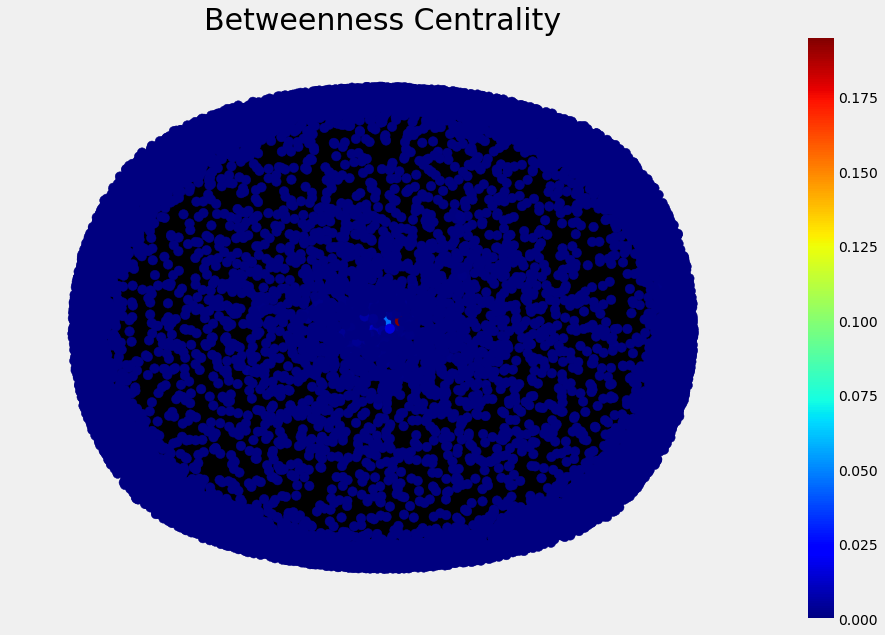

In [ ]:
# Betweenness centrality
fig, ax = plt.subplots(1,1,figsize=(15,10))
print("Calculating")
color = list(dict(betweenness).values())
print("Ploting...")
nx.draw_networkx_edges(G,
                       pos=pos,
                       alpha=0.4, ax=ax)
nodes = nx.draw_networkx_nodes(G,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size=90)
plt.title("Betweenness Centrality", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)
plt.show()

Para a métrica de Betweenness Centrality o grafo indica uma predominância quase unânime de valores menores que 0.025. Isso indica que os nós não estão bem posicionados entre os caminhos mais curtos entre os nós do grafo.


#### Top 10 vértices

In [ ]:
print('Top 10 vértices:')
i = 0
for hashtag in betweennessOrdenados:
  if i == 10:
    break
  print("{:^30} {:5.4f}".format(hashtag, betweenness[hashtag]))
  i += 1

Top 10 vértices:
             luna              0.1956
             btc               0.1953
             eth               0.1050
            crypto             0.0749
             ada               0.0747
             sol               0.0725
             nft               0.0712
             xrp               0.0676
             bnb               0.0615
           bitcoin             0.0505


No Top 10 vértices o intervalo de variação se posiciona entre 0.05 e 0.19. Com o valor inferior se posicionando muito próximo da moda aparente do grafo para essa métrica é percebida uma grande uniformidade entre os nós.


### Eigenvector Centrality

In [ ]:
eigenvector = nx.eigenvector_centrality(G)

In [ ]:
# Gera uma sequência decrescente da eigenvector centrality dos nós
eigenvectorOrdenados = sorted(eigenvector, key=eigenvector.get, reverse=True)

In [ ]:
eigenvectorNos = [eigenvector[hashtag] for hashtag in eigenvectorOrdenados]

#### Gráfico

Calculating
Ploting...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  app.launch_new_instance()


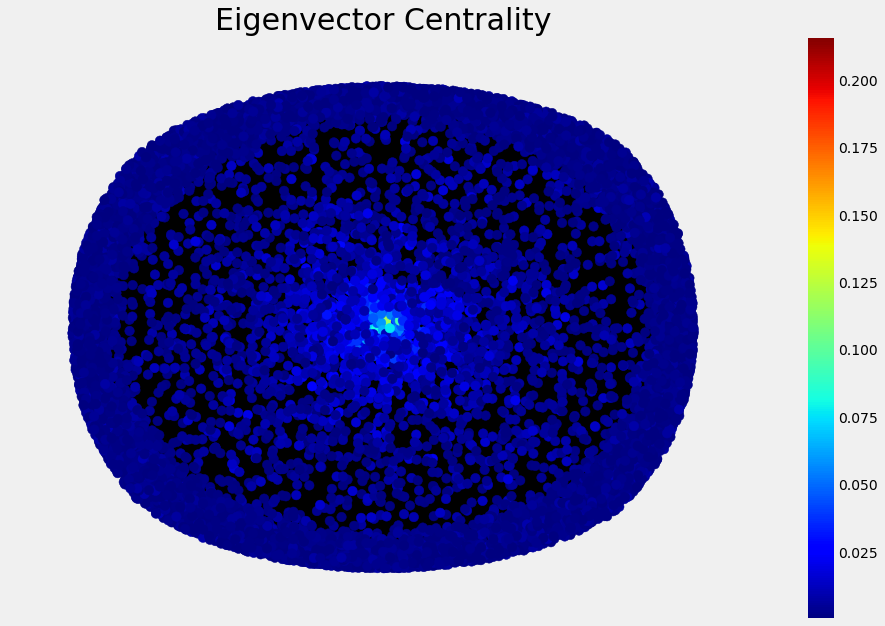

In [ ]:
# Eigenvector centrality
fig, ax = plt.subplots(1,1,figsize=(15,10))
print("Calculating")
color = list(dict(eigenvector).values())
print("Ploting...")
nx.draw_networkx_edges(G,
                       pos=pos,
                       alpha=0.4, ax=ax)
nodes = nx.draw_networkx_nodes(G,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size=90)
plt.title("Eigenvector Centrality", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)
plt.show()

Analisando o gráfico para o Eigenvector Centrality nota-se que a grande maioria dos nós tem valores muito baixos para essa métrica, o que indica que os nós, em geral, não tem conexões com nós importantes. Por isso o Eigenvector Centrality concentra-se num valor abaixo de 0.025.


#### Top 10 vértices

In [ ]:
print('Top 10 vértices:')
i = 0
for hashtag in eigenvectorOrdenados:
  if i == 10:
    break
  print("{:^20} {:5.4f}".format(hashtag, eigenvector[hashtag]))
  i += 1

Top 10 vértices:
        btc          0.2163
        eth          0.2009
       crypto        0.1804
        bnb          0.1621
        nft          0.1607
      bitcoin        0.1605
        xrp          0.1323
        ada          0.1297
   cryptocurrency    0.1189
      ethereum       0.1187


Analisando os Top 10 vértices observa-se que os nós possuem valores relativamente altos (0.21) se comparados com a moda (0.02). Dessa forma, percebe-se que há um nicho de nós importantes que se conectam entre si.


### Análise Decomposição da Rede 2 k-cores mais profundos

Um k-core em uma rede é um sub-grafo de nós com um mínimo de k conexões entre eles. Esses sub-grafos são conjuntos de nós super conectados entre si.


In [ ]:
# Agrupar Kcores do grafo
kcores = list(set([v for k,v in nx.core_number(G).items()]))

#### Listar os 2 k-cores mais profundos

In [ ]:
nosUltimoKCore = [node for node in list(nx.k_core(G, kcores[-1]))]
nosPenultimoKCore = [node for node in list(nx.k_core(G, kcores[-2]))]

In [ ]:
print("Profundidade do último k-core:", kcores[-1])
print("Quantidade de nós no último k-core:", len(nosUltimoKCore))
print("Nós no último k-core:")
print(nosUltimoKCore)

Profundidade do último k-core: 47
Quantidade de nós no último k-core: 113
Nós no último k-core:
['dot', 'mana', 'dogecoin', 'ripple', 'cryptonews', 'hodl', 'sand', 'playtoearn', 'trading', 'xrp', 'altcoins', 'airdrop', 'tron', 'metaverse', 'sxp', 'cro', 'ftm', 'polkadot', 'avax', 'babydogecoin', 'shib', 'btt', 'terra', 'litecoin', 'ceek', '1000xgem', 'news', 'matic', 'shinja', 'nftcollector', 'giveaway', 'blockchain', 'superbowl', 'bscgems', 'nft', 'hot', 'usdt', 'cardano', 'ada', 'eth', 'nftcommunity', 'elonmusk', 'everrise', 'atom', 'eos', 'ltc', 'shibainu', 'xlm', 'raca', 'kripto', 'solana', 'slp', 'cryptocurrencies', 'xrparmy', 'defi', 'memecoin', 'btc', 'nftdrop', 'p2e', 'binancesmartchain', 'web3', 'sol', 'shibarmy', 'bscgem', 'pancakeswap', 'bnb', 'cryptocurrency', 'enj', 'saitama', 'coinmarketcap', 'link', 'passiveincome', 'trx', 'shiba', 'xrpcommunity', 'airdrops', 'avalanche', 'xtz', 'crypto', 'binance', 'near', 'axs', 'gamefi', '100xgem', 'nftgiveaway', 'nftart', 'polygon', 

O k-core mais profundo é composto por 113 nós com uma profundidade de 47.

In [ ]:
print("Profundidade do penúltimo k-core:", kcores[-2])
print("Quantidade de nós no penúltimo k-core:", len(nosPenultimoKCore))
print("Nós no penúltimo k-core:")
print(nosPenultimoKCore)

Profundidade do penúltimo k-core: 46
Quantidade de nós no penúltimo k-core: 137
Nós no penúltimo k-core:
['dot', 'mana', 'dogecoin', 'ripple', 'meta', 'cryptonews', 'hodl', 'sand', 'playtoearn', 'openseanft', 'trading', 'xrp', 'altcoins', 'cmc', 'airdrop', 'tron', 'hbar', 'metaverse', 'cryptoart', 'sxp', 'cro', 'ftm', 'polkadot', 'avax', 'busd', 'nftproject', 'babydogecoin', 'shib', 'btt', 'terra', 'litecoin', 'ceek', '1000xgem', 'news', 'matic', 'shinja', 'nftcollector', 'giveaway', 'blockchain', 'superbowl', 'etherum', 'bscgems', 'nft', 'hot', 'usdt', 'cardano', 'ada', 'eth', 'nftcommunity', 'elonmusk', 'everrise', 'atom', 'altseason', 'eos', 'ltc', 'shibainu', 'xrpl', 'xlm', 'nftgame', 'raca', 'kripto', 'solana', 'slp', 'cryptocurrencies', 'xrparmy', 'defi', 'memecoin', 'btc', 'nftdrop', 'p2e', 'binancesmartchain', 'web3', 'giveaways', 'sol', 'shibarmy', 'bscgem', 'kucoin', 'pancakeswap', 'bnb', 'cryptocurrency', 'kriptopara', 'gaming', 'enj', 'saitama', 'coinmarketcap', 'link', 'pa

Já o penúltimo k-core é composto por 137 nós (24 novos nós além dos 113 do core mais profundo) com uma profundidade de 46.

#### Gráfico com destaque para os 2 k-cores mais profundos

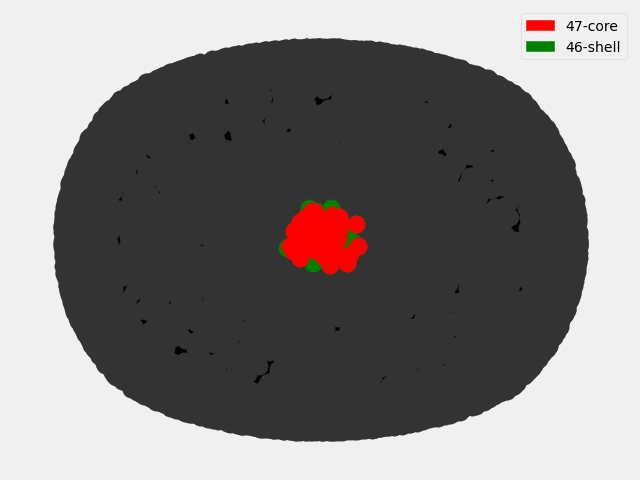

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
nx.draw_networkx_edges(G,
                       pos=pos,
                       alpha=0.4, ax=ax)
nodes = nx.draw_networkx_nodes(G,
                 pos=pos,
                 node_color="#333333")
nodes = nx.draw_networkx_nodes(nosPenultimoKCore,
                 pos=pos,
                 node_color="green")
nodes = nx.draw_networkx_nodes(nosUltimoKCore,
                 pos=pos,
                 node_color="red")
red_patch = mpatches.Patch(color='red', label=f'{kcores[-1]}-core')
green_patch = mpatches.Patch(color='green', label=f'{kcores[-2]}-shell')
plt.legend(handles=[red_patch, green_patch])
plt.axis("off")
plt.show()